In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
!gdown --id '1kX-7qSFWTQcUaypeVaRDUOlItqW8-KQ1' --output level-6-train.csv

Downloading...
From: https://drive.google.com/uc?id=1kX-7qSFWTQcUaypeVaRDUOlItqW8-KQ1
To: /content/level-6-train.csv
100% 288k/288k [00:00<00:00, 53.1MB/s]


In [3]:
train = pd.read_csv("level-6-train.csv")
train.head()

,index,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrososphaera,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;__,Archaea;Thermoplasmatota;Thermoplasmata;Thermoplasmatales;Thermoplasmataceae;uncultured,Archaea;__;__;__;__;__,Bacteria;Abditibacteriota;Abditibacteria;Abditibacteriales;Abditibacteriaceae;Abditibacterium,Bacteria;Acidobacteria;Acidobacteriia;Acidobacteriales;Acidobacteriaceae;PAC001990,Bacteria;Acidobacteria;Blastocatellia;Blastocatellales;PAC000004;EU192989,Bacteria;Acidobacteria;CP011806;CP011806;CP011806;CP011806,Bacteria;Acidobacteria;CP011806;CP011806;PAC002217;PAC002217,Bacteria;Acidobacteria;PAC001813;PAC001813;PAC001813;PAC001813,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC001852,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC002038,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;__,Bacteria;Acidobacteria;Solibacteres;Solibacterales;Bryobacteraceae;PAC002019,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;PAC002281;PAC002281,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001869,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001874,Bacteria;Acidobacteriota;Acidobacteriae;Acidobacteriales;Acidobacteriaceae_(Subgroup_1);uncultured,Bacteria;Acidobacteriota;Acidobacteriae;Bryobacterales;Bryobacteraceae;Bryobacter,Bacteria;Acidobacteriota;Blastocatellia;11-24;__;__,Bacteria;Acidobacteriota;Blastocatellia;11-24;uncultured_Pelobacter_sp.;,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Aridibacter,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Blastocatella,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;__,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;uncultured,Bacteria;Acidobacteriota;Blastocatellia;Elev-16S-573;uncultured_microorganism;,Bacteria;Acidobacteriota;Blastocatellia;Pyrinomonadales;Pyrinomonadaceae;RB41,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;Acidobacteria_bacterium;,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;__;__,Bacteria;Acidobacteriota;Subgroup_11;__;__;__,Bacteria;Acidobacteriota;Subgroup_11;uncultured_sponge_symbiont_PAUC37f;;__,Bacteria;Acidobacteriota;Subgroup_18;alkali_sediment_metagenome;;__,Bacteria;Acidobacteriota;Subgroup_22;__;__;__,Bacteria;Acidobacteriota;Subgroup_25;uncultured_Firmicutes_bacterium;;__,Bacteria;Acidobacteriota;Subgroup_5;uncultured_Acidobacteriales_bacterium;;__,Bacteria;Acidobacteriota;Thermoanaerobaculia;Thermoanaerobaculales;Thermoanaerobaculaceae;Subgroup_10,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;__;__,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;agricultural_soil_bacterium_SC-I-8;,...,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;Steroidobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Arenimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Luteimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Lysobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Pseudoxanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Stenotrophomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Thermomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Vulcaniibacterium,Bacteria;Proteobac

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Columns: 710 entries, index to Cancer
dtypes: float64(587), int64(121), object(2)
memory usage: 682.4+ KB


In [5]:
not_select = ["index", "Cancer", "Merged"]
train_select = train.drop(not_select,axis=1)
train_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Columns: 707 entries, Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus to Unassigned;__;__;__;__;__
dtypes: float64(587), int64(120)
memory usage: 679.5 KB


In [6]:
CAT_COL = ["index", "Cancer"]

NUM_COL=[]
for i in range(len(train.columns)):
  NUM_COL.append(train.columns[i])
NUM_COL.remove('index')
NUM_COL.remove('Cancer')

cat_col = []
num_col = []
for col in train_select:
  if col in CAT_COL:
    cat_col.append(col)
  elif col in NUM_COL:
    num_col.append(col)

for col in cat_col:
  if train_select[col].dtype != "O":
    # print(col)
    train_select[col] = train_select[col].astype(str)

df_cat_select = train_select.loc[:,cat_col] # take all the categorical columns
#df_cat_select = pd.get_dummies(df_cat_select) # one hot encoding

df_num_select = train_select.loc[:,num_col] # take all the numerical columns
df_final_select_train = pd.concat([df_cat_select, df_num_select], axis=1) # concat categorical/numerical data

In [7]:
df_final_select_train.head()

,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrososphaera,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;__,Archaea;Thermoplasmatota;Thermoplasmata;Thermoplasmatales;Thermoplasmataceae;uncultured,Archaea;__;__;__;__;__,Bacteria;Abditibacteriota;Abditibacteria;Abditibacteriales;Abditibacteriaceae;Abditibacterium,Bacteria;Acidobacteria;Acidobacteriia;Acidobacteriales;Acidobacteriaceae;PAC001990,Bacteria;Acidobacteria;Blastocatellia;Blastocatellales;PAC000004;EU192989,Bacteria;Acidobacteria;CP011806;CP011806;CP011806;CP011806,Bacteria;Acidobacteria;CP011806;CP011806;PAC002217;PAC002217,Bacteria;Acidobacteria;PAC001813;PAC001813;PAC001813;PAC001813,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC001852,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC002038,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;__,Bacteria;Acidobacteria;Solibacteres;Solibacterales;Bryobacteraceae;PAC002019,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;PAC002281;PAC002281,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001869,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001874,Bacteria;Acidobacteriota;Acidobacteriae;Acidobacteriales;Acidobacteriaceae_(Subgroup_1);uncultured,Bacteria;Acidobacteriota;Acidobacteriae;Bryobacterales;Bryobacteraceae;Bryobacter,Bacteria;Acidobacteriota;Blastocatellia;11-24;__;__,Bacteria;Acidobacteriota;Blastocatellia;11-24;uncultured_Pelobacter_sp.;,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Aridibacter,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Blastocatella,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;__,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;uncultured,Bacteria;Acidobacteriota;Blastocatellia;Elev-16S-573;uncultured_microorganism;,Bacteria;Acidobacteriota;Blastocatellia;Pyrinomonadales;Pyrinomonadaceae;RB41,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;Acidobacteria_bacterium;,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;__;__,Bacteria;Acidobacteriota;Subgroup_11;__;__;__,Bacteria;Acidobacteriota;Subgroup_11;uncultured_sponge_symbiont_PAUC37f;;__,Bacteria;Acidobacteriota;Subgroup_18;alkali_sediment_metagenome;;__,Bacteria;Acidobacteriota;Subgroup_22;__;__;__,Bacteria;Acidobacteriota;Subgroup_25;uncultured_Firmicutes_bacterium;;__,Bacteria;Acidobacteriota;Subgroup_5;uncultured_Acidobacteriales_bacterium;;__,Bacteria;Acidobacteriota;Thermoanaerobaculia;Thermoanaerobaculales;Thermoanaerobaculaceae;Subgroup_10,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;__;__,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;agricultural_soil_bacterium_SC-I-8;,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;uncultured_Holophaga_sp.;,...,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Hydrocarboniphaga,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Nevskia,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;Steroidobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Arenimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Luteimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Lysobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Pseudoxanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;

In [8]:
!gdown --id '1MaKUC_AsqQmQQLhwqwmw3dC_u5GBoMYr' --output level-6-test.csv

Downloading...
From: https://drive.google.com/uc?id=1MaKUC_AsqQmQQLhwqwmw3dC_u5GBoMYr
To: /content/level-6-test.csv
100% 550k/550k [00:00<00:00, 36.7MB/s]


In [9]:
test = pd.read_csv("level-6-test.csv")
test.head()

,index,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrososphaera,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;__,Archaea;Thermoplasmatota;Thermoplasmata;Thermoplasmatales;Thermoplasmataceae;uncultured,Archaea;__;__;__;__;__,Bacteria;Abditibacteriota;Abditibacteria;Abditibacteriales;Abditibacteriaceae;Abditibacterium,Bacteria;Acidobacteria;Acidobacteriia;Acidobacteriales;Acidobacteriaceae;PAC001990,Bacteria;Acidobacteria;Blastocatellia;Blastocatellales;PAC000004;EU192989,Bacteria;Acidobacteria;CP011806;CP011806;CP011806;CP011806,Bacteria;Acidobacteria;CP011806;CP011806;PAC002217;PAC002217,Bacteria;Acidobacteria;PAC001813;PAC001813;PAC001813;PAC001813,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC001852,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC002038,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;__,Bacteria;Acidobacteria;Solibacteres;Solibacterales;Bryobacteraceae;PAC002019,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;PAC002281;PAC002281,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001869,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001874,Bacteria;Acidobacteriota;Acidobacteriae;Acidobacteriales;Acidobacteriaceae_(Subgroup_1);uncultured,Bacteria;Acidobacteriota;Acidobacteriae;Bryobacterales;Bryobacteraceae;Bryobacter,Bacteria;Acidobacteriota;Blastocatellia;11-24;__;__,Bacteria;Acidobacteriota;Blastocatellia;11-24;uncultured_Pelobacter_sp.;,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Aridibacter,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Blastocatella,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;__,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;uncultured,Bacteria;Acidobacteriota;Blastocatellia;Elev-16S-573;uncultured_microorganism;,Bacteria;Acidobacteriota;Blastocatellia;Pyrinomonadales;Pyrinomonadaceae;RB41,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;Acidobacteria_bacterium;,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;__;__,Bacteria;Acidobacteriota;Subgroup_11;__;__;__,Bacteria;Acidobacteriota;Subgroup_11;uncultured_sponge_symbiont_PAUC37f;;__,Bacteria;Acidobacteriota;Subgroup_18;alkali_sediment_metagenome;;__,Bacteria;Acidobacteriota;Subgroup_22;__;__;__,Bacteria;Acidobacteriota;Subgroup_25;uncultured_Firmicutes_bacterium;;__,Bacteria;Acidobacteriota;Subgroup_5;uncultured_Acidobacteriales_bacterium;;__,Bacteria;Acidobacteriota;Thermoanaerobaculia;Thermoanaerobaculales;Thermoanaerobaculaceae;Subgroup_10,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;__;__,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;agricultural_soil_bacterium_SC-I-8;,...,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;Steroidobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Arenimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Luteimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Lysobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Pseudoxanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Stenotrophomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Thermomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Vulcaniibacterium,Bacteria;Proteobac

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Columns: 710 entries, index to Cancer
dtypes: float64(295), int64(413), object(2)
memory usage: 1.6+ MB


In [11]:
not_select = ["index", "Cancer", "Merged"]
test_select = test.drop(not_select,axis=1)
test_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Columns: 707 entries, Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus to Unassigned;__;__;__;__;__
dtypes: float64(295), int64(412)
memory usage: 1.6 MB


In [12]:
cat_col = []
num_col = []
for col in test_select:
  if col in CAT_COL:
    cat_col.append(col)
  elif col in NUM_COL:
    num_col.append(col)

for col in cat_col:
  if test_select[col].dtype != "O":
    # print(col)
    test_select[col] = test_select[col].astype(str)

df_cat_select = test_select.loc[:,cat_col] # take all the categorical columns
#df_cat_select = pd.get_dummies(df_cat_select) # one hot encoding

df_num_select = test_select.loc[:,num_col] # take all the numerical columns
df_final_select_test = pd.concat([df_cat_select, df_num_select], axis=1) # concat categorical/numerical data

In [13]:
df_final_select_test.head()

,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrososphaera,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;__,Archaea;Thermoplasmatota;Thermoplasmata;Thermoplasmatales;Thermoplasmataceae;uncultured,Archaea;__;__;__;__;__,Bacteria;Abditibacteriota;Abditibacteria;Abditibacteriales;Abditibacteriaceae;Abditibacterium,Bacteria;Acidobacteria;Acidobacteriia;Acidobacteriales;Acidobacteriaceae;PAC001990,Bacteria;Acidobacteria;Blastocatellia;Blastocatellales;PAC000004;EU192989,Bacteria;Acidobacteria;CP011806;CP011806;CP011806;CP011806,Bacteria;Acidobacteria;CP011806;CP011806;PAC002217;PAC002217,Bacteria;Acidobacteria;PAC001813;PAC001813;PAC001813;PAC001813,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC001852,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC002038,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;__,Bacteria;Acidobacteria;Solibacteres;Solibacterales;Bryobacteraceae;PAC002019,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;PAC002281;PAC002281,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001869,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001874,Bacteria;Acidobacteriota;Acidobacteriae;Acidobacteriales;Acidobacteriaceae_(Subgroup_1);uncultured,Bacteria;Acidobacteriota;Acidobacteriae;Bryobacterales;Bryobacteraceae;Bryobacter,Bacteria;Acidobacteriota;Blastocatellia;11-24;__;__,Bacteria;Acidobacteriota;Blastocatellia;11-24;uncultured_Pelobacter_sp.;,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Aridibacter,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Blastocatella,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;__,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;uncultured,Bacteria;Acidobacteriota;Blastocatellia;Elev-16S-573;uncultured_microorganism;,Bacteria;Acidobacteriota;Blastocatellia;Pyrinomonadales;Pyrinomonadaceae;RB41,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;Acidobacteria_bacterium;,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;__;__,Bacteria;Acidobacteriota;Subgroup_11;__;__;__,Bacteria;Acidobacteriota;Subgroup_11;uncultured_sponge_symbiont_PAUC37f;;__,Bacteria;Acidobacteriota;Subgroup_18;alkali_sediment_metagenome;;__,Bacteria;Acidobacteriota;Subgroup_22;__;__;__,Bacteria;Acidobacteriota;Subgroup_25;uncultured_Firmicutes_bacterium;;__,Bacteria;Acidobacteriota;Subgroup_5;uncultured_Acidobacteriales_bacterium;;__,Bacteria;Acidobacteriota;Thermoanaerobaculia;Thermoanaerobaculales;Thermoanaerobaculaceae;Subgroup_10,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;__;__,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;agricultural_soil_bacterium_SC-I-8;,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;uncultured_Holophaga_sp.;,...,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Hydrocarboniphaga,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Nevskia,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;Steroidobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Arenimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Luteimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Lysobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Pseudoxanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;

#DNN

In [14]:
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [15]:
target_var = 'Cancer'
features = list(df_final_select_train.columns)
# 目標變量的類別
Class = train[target_var].unique()
# 目標變量的類別字典
Class_dict = dict(zip(Class, range(len(Class))))
# 增加一列target, 將目標變量進行編碼
train['target'] = train[target_var].apply(lambda x: Class_dict[x])
# 對目標變量進行0-1編碼(One-hot Encoding)
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(train['target'])
label2 = np.zeros((123,1))

for i in range(len(transformed_labels)):
  if transformed_labels[i][0] == 0:
    label2[i][0] = np.int(1)
  elif transformed_labels[i][0] == 1:
    label2[i][0] = np.int(0)

transformed_labels = np.concatenate((transformed_labels, label2),axis=1)

y_bin_labels_train = []  # 對多分類進行0-1編碼的變量
for i in range(transformed_labels.shape[1]):
    y_bin_labels_train.append( 'y' + str(i))
    train['y' + str(i)] = transformed_labels[:, i]

In [16]:
target_var = 'Cancer'
features = list(df_final_select_test.columns)
# 目標變量的類別
Class = test[target_var].unique()
# 目標變量的類別字典
Class_dict = dict(zip(Class, range(len(Class))))
# 增加一列target, 將目標變量進行編碼
test['target'] = test[target_var].apply(lambda x: Class_dict[x])
# 對目標變量進行0-1編碼(One-hot Encoding)
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = []
transformed_labels = lb.transform(test['target'])
label3 = np.zeros((291,1))

for i in range(len(transformed_labels)):
  if transformed_labels[i][0] == 0:
    label3[i][0] = np.int(1)
  elif transformed_labels[i][0] == 1:
    label3[i][0] = np.int(0)

transformed_labels = np.concatenate((transformed_labels, label3),axis=1)
y_bin_labels_test = []  # 對多分類進行0-1編碼的變量
for i in range(transformed_labels.shape[1]):
    y_bin_labels_test.append( 'y' + str(i))
    test['y' + str(i)] = transformed_labels[:, i]

In [38]:
# 將數據集分為訓練集和測試集
train_x = df_final_select_train[features]
test_x = df_final_select_test[features]
train_y = train[y_bin_labels_train]
test_y = test[y_bin_labels_test]

In [60]:
np.random.seed(5)
# model
init = K.initializers.glorot_uniform(seed=1)
model = K.models.Sequential()
model.add(K.layers.Dense(units=28, input_dim=707, kernel_initializer=init, activation='relu'))
# model.add(K.layers.Dense(units=2048, kernel_initializer=init, activation= 'relu'))
# model.add(K.layers.Dense(units=1024, kernel_initializer=init, activation= 'relu'))
model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='relu'))

In [61]:
# 訓練模型
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
# opt = K.optimizers.Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
31/31 [==============================] - 1s 27ms/step - loss: nan - accuracy: 0.4634 - val_loss: nan - val_accuracy: 0.3883
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 7.0153 - accuracy: 0.4553 - val_loss: 5.2992 - val_accuracy: 0.4158
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 6.1613 - accuracy: 0.4715 - val_loss: 4.1370 - val_accuracy: 0.4261
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 5.5548 - accuracy: 0.4715 - val_loss: 1.9035 - val_accuracy: 0.4158
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 2.9587 - accuracy: 0.5122 - val_loss: 1.1311 - val_accuracy: 0.4227
Epoch 6/50
31/31 [==============================] - 0s 7ms/step - loss: 0.7406 - accuracy: 0.4715 - val_loss: 1.0115 - val_accuracy: 0.4399
Epoch 7/50
31/31 [==============================] - 0s 8ms/step - loss: 0.7237 - accuracy: 0.4878 - val_loss: 0.9907 - val_accuracy: 0.4467
Epoch 8/50
31/31 [=======

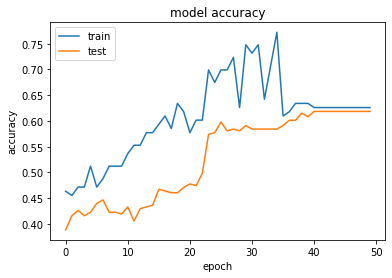

In [62]:
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#PH-CNN
##reference:
###https://github.com/dfioravanti/phylogenetic-cnn
###https://www.tensorflow.org/tutorials/images/cnn

In [63]:
import os
from tensorflow.keras import datasets, layers, models

##Import coordinate data

In [64]:
!gdown --id '1myMxkf61hmEYglDUO9K_Qm9NI2Utsc0J' --output ordinate_train.csv
C_train = pd.read_csv("ordinate_train.csv")

Downloading...
From: https://drive.google.com/uc?id=1myMxkf61hmEYglDUO9K_Qm9NI2Utsc0J
To: /content/ordinate_train.csv
100% 192k/192k [00:00<00:00, 27.3MB/s]


In [65]:
C_train.head()

,index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,Merged
0,SRR8902009,3.186100,1.042724,-0.174329,0.001493,0.010047,0.000776,0.015667,-0.007203,0.002219,0.017374,-0.097872,0.044548,-0.113766,-0.018531,-0.002285,-0.026189,0.231185,0.007633,0.010375,0.000533,-0.002708,0.001174,-0.002740,-0.003506,-0.000960,-0.032955,0.021492,-0.039451,-0.079327,0.028608,0.034598,0.004006,-0.005856,-0.035803,0.009803,-0.001574,-0.000119,0.003771,-0.050612,...,0.000424,0.001449,0.015140,0.011137,0.016207,-0.000405,-0.001733,-0.000044,0.007971,-0.001957,-0.003477,-0.002795,-0.001236,0.005646,0.000237,-0.005372,-0.000591,-0.000050,0.000594,-0.000944,-0.020129,0.005547,0.008932,0.001317,-0.001067,0.000306,-0.000028,2.570000e-07,-1.830000e-06,1.230000e-06,-7.130000e-06,3.150000e-06,3.900000e-07,-1.630000e-06,-7.900000e-06,-1.090000e-06,1.120000e-06,1.230000e-08,-8.500000e-09,43058
1,SRR8902010,3.008845,0.703913,-0.111238,0.012361,0.024388,-0.001723,0.002494,0.004657,0.001964,-0.022058,0.189387,0.037394,-0.056438,-0.009320,-0.005205,0.003616,0.000965,0.001457,0.002522,0.000327,-0.000405,-0.001381,-0.000709,0.000008,0.000461,-0.005153,0.003776,-0.008453,-0.018364,0.005796,0.009545,0.001595,-0.002093,0.016446,0.000780,-0.001273,-0.000417,-0.000901,0.011022,...,-0.000132,-0.000265,-0.003321,-0.001072,-0.000752,-0.010441,0.001608,0.000056,-0.006259,0.001766,0.000602,-0.005590,-0.002189,-0.002641,-0.000006,-0.000906,0.003454,0.000618,0.002017,0.000098,-0.000250,0.000360,0.000363,0.000010,-0.000129,0.000010,-0.000005,4.640000e-06,-1.360000e-07,-2.180000e-06,9.350000e-07,-7.060000e-07,-1.330000e-07,2.070000e-07,7.700000e-07,8.300000e-08,-9.560000e-08,-4.950000e-10,5.760000e-10,53224
2,SRR8902011,2.527694,0.111656,-0.013524,0.011594,0.018893,-0.001919,-0.005311,0.004153,-0.002072,0.016150,-0.185878,-0.071437,0.126697,0.021039,0.010430,-0.005781,-0.014209,-0.003648,-0.005437,-0.000693,0.000504,0.003489,0.001427,-0.001610,-0.009657,-0.135210,0.008014,-0.006359,-0.007232,0.000097,0.001950,0.000215,0.000689,0.113266,-0.028553,0.007180,0.003007,0.014252,-0.152417,...,-0.000079,-0.000546,-0.007202,-0.003686,-0.004677,-0.007298,0.001094,0.000019,-0.006211,0.000857,0.000414,0.001558,0.000697,0.000761,-0.000036,-0.000801,0.000989,0.000146,0.001749,0.000116,0.000060,0.000261,-0.000021,-0.000079,-0.000612,0.000012,0.000003,-9.760000e-07,6.550000e-07,1.180000e-06,1.780000e-06,-2.290000e-07,1.460000e-07,1.300000e-07,7.740000e-07,1.390000e-07,-1.120000e-07,8.940000e-10,1.330000e-09,38463
3,SRR8902012,2.233100,-0.299058,0.049786,-0.004658,-0.015397,0.003053,0.013865,-0.013966,0.002338,0.030236,-0.149826,0.116350,-0.350271,-0.066774,-0.031292,0.038897,-0.027400,0.027268,0.030748,0.005799,0.016639,-0.024091,0.012032,0.013194,-0.008785,-0.112317,-0.046834,0.086503,0.175018,-0.068206,-0.075029,-0.008923,0.015891,-0.091221,0.001865,-0.000600,0.001029,0.007911,-0.072605,...,-0.001910,-0.002455,-0.005700,0.002592,0.006256,-0.016137,0.000254,-0.000050,-0.009677,0.000583,-0.003340,-0.000034,-0.000009,0.000320,0.000007,-0.000384,0.000246,0.000159,-0.000940,-0.000116,-0.000474,-0.000040,0.000638,-0.000031,-0.000354,0.000022,0.000001,2.890000e-06,3.940000e-07,5.260000e-07,3.110000e-07,9.540000e-08,2.460000e-07,-2.530000e-07,-1.180000e-06,-1.670000e-07,1.950000e-07,6.380000e-09,-1.310000e-09,32140
4,SRR8902013,2.531365,0.049526,-0.000710,0.013867,0.021054,-0.002372,-0.007639,0.008250,-0.000830,-0.012094,0.051286,-0.043026,0.108160,0.018935,0.007326,0.000489,-0.059379,-0.005942,-0.007484,-0.000913,-0.000393,0.003239,0.000469,-0.000976,-0.004322,-0.056445,0.002504,-0.000214,0.002197,-0.001366,-0.001792,-0.000350,0.000629,-0.005531,0.000419,-0.000033,-0.000041,-0.000703,0.009014,...,-0.000129,-0.000071,0.001135,0.002066,0.003558,-0.005246,0.000217,0.000008,-0.001426,0.000611,0.

In [66]:
not_select=['index', 'Merged']
C_final_train = C_train.drop(not_select,axis=1)
C_final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Columns: 130 entries, 1 to 130
dtypes: float64(130)
memory usage: 125.0 KB


In [67]:
C_final_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130
0,3.186100,1.042724,-0.174329,0.001493,0.010047,0.000776,0.015667,-0.007203,0.002219,0.017374,-0.097872,0.044548,-0.113766,-0.018531,-0.002285,-0.026189,0.231185,0.007633,0.010375,0.000533,-0.002708,0.001174,-0.002740,-0.003506,-0.000960,-0.032955,0.021492,-0.039451,-0.079327,0.028608,0.034598,0.004006,-0.005856,-0.035803,0.009803,-0.001574,-0.000119,0.003771,-0.050612,-0.003362,...,-0.013212,0.000424,0.001449,0.015140,0.011137,0.016207,-0.000405,-0.001733,-0.000044,0.007971,-0.001957,-0.003477,-0.002795,-0.001236,0.005646,0.000237,-0.005372,-0.000591,-0.000050,0.000594,-0.000944,-0.020129,0.005547,0.008932,0.001317,-0.001067,0.000306,-0.000028,2.570000e-07,-1.830000e-06,1.230000e-06,-7.130000e-06,3.150000e-06,3.900000e-07,-1.630000e-06,-7.900000e-06,-1.090000e-06,1.120000e-06,1.230000e-08,-8.500000e-09
1,3.008845,0.703913,-0.111238,0.012361,0.024388,-0.001723,0.002494,0.004657,0.001964,-0.022058,0.189387,0.037394,-0.056438,-0.009320,-0.005205,0.003616,0.000965,0.001457,0.002522,0.000327,-0.000405,-0.001381,-0.000709,0.000008,0.000461,-0.005153,0.003776,-0.008453,-0.018364,0.005796,0.009545,0.001595,-0.002093,0.016446,0.000780,-0.001273,-0.000417,-0.000901,0.011022,-0.000345,...,-0.010828,-0.000132,-0.000265,-0.003321,-0.001072,-0.000752,-0.010441,0.001608,0.000056,-0.006259,0.001766,0.000602,-0.005590,-0.002189,-0.002641,-0.000006,-0.000906,0.003454,0.000618,0.002017,0.000098,-0.000250,0.000360,0.000363,0.000010,-0.000129,0.000010,-0.000005,4.640000e-06,-1.360000e-07,-2.180000e-06,9.350000e-07,-7.060000e-07,-1.330000e-07,2.070000e-07,7.700000e-07,8.300000e-08,-9.560000e-08,-4.950000e-10,5.760000e-10
2,2.527694,0.111656,-0.013524,0.011594,0.018893,-0.001919,-0.005311,0.004153,-0.002072,0.016150,-0.185878,-0.071437,0.126697,0.021039,0.010430,-0.005781,-0.014209,-0.003648,-0.005437,-0.000693,0.000504,0.003489,0.001427,-0.001610,-0.009657,-0.135210,0.008014,-0.006359,-0.007232,0.000097,0.001950,0.000215,0.000689,0.113266,-0.028553,0.007180,0.003007,0.014252,-0.152417,-0.006012,...,0.012667,-0.000079,-0.000546,-0.007202,-0.003686,-0.004677,-0.007298,0.001094,0.000019,-0.006211,0.000857,0.000414,0.001558,0.000697,0.000761,-0.000036,-0.000801,0.000989,0.000146,0.001749,0.000116,0.000060,0.000261,-0.000021,-0.000079,-0.000612,0.000012,0.000003,-9.760000e-07,6.550000e-07,1.180000e-06,1.780000e-06,-2.290000e-07,1.460000e-07,1.300000e-07,7.740000e-07,1.390000e-07,-1.120000e-07,8.940000e-10,1.330000e-09
3,2.233100,-0.299058,0.049786,-0.004658,-0.015397,0.003053,0.013865,-0.013966,0.002338,0.030236,-0.149826,0.116350,-0.350271,-0.066774,-0.031292,0.038897,-0.027400,0.027268,0.030748,0.005799,0.016639,-0.024091,0.012032,0.013194,-0.008785,-0.112317,-0.046834,0.086503,0.175018,-0.068206,-0.075029,-0.008923,0.015891,-0.091221,0.001865,-0.000600,0.001029,0.007911,-0.072605,-0.004392,...,-0.006921,-0.001910,-0.002455,-0.005700,0.002592,0.006256,-0.016137,0.000254,-0.000050,-0.009677,0.000583,-0.003340,-0.000034,-0.000009,0.000320,0.000007,-0.000384,0.000246,0.000159,-0.000940,-0.000116,-0.000474,-0.000040,0.000638,-0.000031,-0.000354,0.000022,0.000001,2.890000e-06,3.940000e-07,5.260000e-07,3.110000e-07,9.540000e-08,2.460000e-07,-2.530000e-07,-1.180000e-06,-1.670000e-07,1.950000e-07,6.380000e-09,-1.310000e-09
4,2.531365,0.049526,-0.000710,0.013867,0.021054,-0.002372,-0.007639,0.008250,-0.000830,-0.012094,0.051286,-0.043026,0.108160,0.018935,0.007326,0.000489,-0.059379,-0.005942,-0.007484,-0.000913,-0.000393,0.003239,0.000469,-0.000976,-0.004322,-0.056445,0.002504,-0.000214,0.002197,-0.001366,-0.001792,-0.000350,0.000629,-0.005531,0.000419,-0.000033,-0.000041,-0.000703,0.009014,0.000698,...,-0.001896,-0.000129,-0.000071,0.001135,0.002066,0.003558,-0.005246,0.000217,0.000008,-0.001426

In [68]:
!gdown --id '1E97dcVIaeaRQB7O0MpENzg33AwLOdM7y' --output ordinate_test.csv
C_test = pd.read_csv("ordinate_test.csv")

Downloading...
From: https://drive.google.com/uc?id=1E97dcVIaeaRQB7O0MpENzg33AwLOdM7y
To: /content/ordinate_test.csv
100% 454k/454k [00:00<00:00, 65.6MB/s]


In [69]:
C_test.head()

,index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,Merged
0,SRR3991006,-1.063221,-0.000890,-0.056303,-0.327487,0.241850,-0.035349,-0.139683,-0.014465,-0.006281,-0.012729,-0.007340,0.079055,0.041298,-0.028810,-0.032688,0.038815,0.005703,0.197918,-0.037324,0.113422,0.042804,0.065022,-0.068209,-0.045582,0.032991,-0.000960,0.043257,0.032389,-0.016524,-0.032913,-0.015252,0.021287,-0.066484,0.001702,0.026034,0.024719,0.020205,0.012672,-0.004387,...,0.001408,0.004126,0.001637,0.000346,-0.000982,0.000604,0.008630,0.002458,-0.000013,0.002410,-0.000292,0.001329,-0.001739,-0.000085,0.000438,-0.000029,0.000324,-0.001745,-0.000123,0.001268,0.000013,0.000023,-0.000021,0.000831,-0.000143,-0.000393,2.660000e-07,-3.520000e-07,8.030000e-06,-8.670000e-07,-5.730000e-08,-3.910000e-08,4.970000e-07,0.000002,-2.820000e-07,-3.240000e-08,1.500000e-08,-4.370000e-11,-2.110000e-10,2634
1,SRR3991007,-1.121573,0.018697,0.066428,-0.250989,0.201690,-0.183097,-0.144150,0.039746,-0.075367,0.054584,0.013348,-0.085611,-0.053006,0.129183,-0.105265,-0.038981,-0.001994,-0.030685,0.025948,-0.071374,0.044307,0.023991,-0.069614,0.106666,-0.048180,-0.001825,-0.087798,0.053568,-0.035777,-0.006410,0.043994,0.024857,0.006379,-0.010443,-0.046189,0.041726,-0.009644,0.039749,0.007331,...,0.000508,0.003923,0.003539,0.003001,-0.004400,-0.000067,0.007727,-0.001258,0.000139,0.004220,-0.000386,0.000753,0.000214,-0.000236,-0.000335,0.000072,-0.000161,0.000693,-0.000028,0.000377,0.000037,-0.000028,-0.000033,0.000795,-0.000096,0.000731,1.830000e-07,-3.290000e-07,8.620000e-06,-1.060000e-06,-9.880000e-08,-4.550000e-09,2.100000e-07,0.000001,-1.530000e-07,-1.820000e-08,9.260000e-09,-3.500000e-11,-1.350000e-10,1839
2,SRR3991008,-1.112753,-0.073487,-0.435167,0.150113,0.112160,-0.057806,-0.178187,0.075639,-0.058367,-0.088307,-0.007658,-0.038113,-0.000633,-0.063160,-0.093464,0.040745,0.009390,-0.009595,-0.007112,-0.062988,0.099152,-0.109079,-0.008331,-0.006650,-0.022766,0.004067,0.028542,-0.047460,0.012241,-0.030385,-0.015911,0.053007,-0.051829,0.011633,0.071712,-0.054710,0.004756,-0.056072,-0.014798,...,0.002440,0.002629,0.002606,-0.009270,0.002257,-0.001682,-0.007390,0.001522,-0.000189,-0.003119,0.000172,0.001712,-0.005059,0.000177,-0.001130,0.000064,-0.000205,0.001136,0.000266,-0.002918,-0.000107,0.000091,0.000091,-0.002235,0.000272,-0.001036,-2.860000e-07,6.430000e-07,-1.490000e-05,1.730000e-06,1.580000e-07,3.790000e-08,-7.410000e-07,-0.000004,4.710000e-07,5.510000e-08,-2.750000e-08,9.090000e-11,3.730000e-10,5166
3,SRR3991009,-0.957607,0.032730,-0.017498,-0.057703,-0.197864,0.019005,-0.055458,-0.139391,0.022851,0.187669,0.030657,-0.048854,-0.006826,0.043355,-0.050929,0.070679,0.012456,-0.014065,-0.027233,0.023978,0.010681,0.010293,-0.024378,-0.025922,-0.006205,-0.000182,-0.019372,-0.025085,-0.001481,0.000185,-0.032904,0.022452,-0.007442,0.004212,0.020405,-0.023984,-0.009472,-0.000079,-0.004149,...,-0.004262,0.003840,-0.001862,0.001016,0.000277,-0.000139,-0.002490,-0.002259,-0.000158,-0.002385,0.000157,-0.000003,-0.000706,0.000051,0.000507,-0.000008,-0.000077,0.000363,0.000149,-0.001948,0.000041,-0.000036,-0.000014,-0.000514,0.000108,0.001027,-1.170000e-07,1.020000e-07,2.590000e-07,-7.910000e-08,8.530000e-09,-5.870000e-08,6.600000e-07,0.000003,-3.870000e-07,-4.500000e-08,2.010000e-08,-3.200000e-11,-3.290000e-10,5558
4,SRR3991010,-1.189938,-0.064010,-0.270061,0.542779,-0.041676,-0.010052,0.154654,0.074954,0.121533,0.144091,0.028166,-0.080478,0.028010,-0.062791,-0.083148,0.045290,-0.001376,0.114353,0.168947,-0.067052,-0.025138,-0.035721,-0.087330,-0.068493,0.015619,-0.002993,-0.051594,0.030723,-0.049889,-0.028343,-0.044244,0.065101,-0.011382,0.006923,0.044005,-0.031631,0.023530,-0.039807,-0.013315,...,-0.000030,-0.001658,-0.006055,0.006143,0.001152,0.001264,0.000144,-0.005020,0.

In [70]:
not_select=['index', 'Merged']
C_final_test = C_test.drop(not_select,axis=1)
C_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Columns: 130 entries, 1 to 130
dtypes: float64(130)
memory usage: 295.7 KB


In [71]:
C_final_test.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130
0,-1.063221,-0.000890,-0.056303,-0.327487,0.241850,-0.035349,-0.139683,-0.014465,-0.006281,-0.012729,-0.007340,0.079055,0.041298,-0.028810,-0.032688,0.038815,0.005703,0.197918,-0.037324,0.113422,0.042804,0.065022,-0.068209,-0.045582,0.032991,-0.000960,0.043257,0.032389,-0.016524,-0.032913,-0.015252,0.021287,-0.066484,0.001702,0.026034,0.024719,0.020205,0.012672,-0.004387,0.039230,...,-0.001144,0.001408,0.004126,0.001637,0.000346,-0.000982,0.000604,0.008630,0.002458,-0.000013,0.002410,-0.000292,0.001329,-0.001739,-0.000085,0.000438,-0.000029,0.000324,-0.001745,-0.000123,0.001268,0.000013,0.000023,-0.000021,0.000831,-0.000143,-0.000393,2.660000e-07,-3.520000e-07,8.030000e-06,-8.670000e-07,-5.730000e-08,-3.910000e-08,4.970000e-07,0.000002,-2.820000e-07,-3.240000e-08,1.500000e-08,-4.370000e-11,-2.110000e-10
1,-1.121573,0.018697,0.066428,-0.250989,0.201690,-0.183097,-0.144150,0.039746,-0.075367,0.054584,0.013348,-0.085611,-0.053006,0.129183,-0.105265,-0.038981,-0.001994,-0.030685,0.025948,-0.071374,0.044307,0.023991,-0.069614,0.106666,-0.048180,-0.001825,-0.087798,0.053568,-0.035777,-0.006410,0.043994,0.024857,0.006379,-0.010443,-0.046189,0.041726,-0.009644,0.039749,0.007331,-0.008671,...,-0.000658,0.000508,0.003923,0.003539,0.003001,-0.004400,-0.000067,0.007727,-0.001258,0.000139,0.004220,-0.000386,0.000753,0.000214,-0.000236,-0.000335,0.000072,-0.000161,0.000693,-0.000028,0.000377,0.000037,-0.000028,-0.000033,0.000795,-0.000096,0.000731,1.830000e-07,-3.290000e-07,8.620000e-06,-1.060000e-06,-9.880000e-08,-4.550000e-09,2.100000e-07,0.000001,-1.530000e-07,-1.820000e-08,9.260000e-09,-3.500000e-11,-1.350000e-10
2,-1.112753,-0.073487,-0.435167,0.150113,0.112160,-0.057806,-0.178187,0.075639,-0.058367,-0.088307,-0.007658,-0.038113,-0.000633,-0.063160,-0.093464,0.040745,0.009390,-0.009595,-0.007112,-0.062988,0.099152,-0.109079,-0.008331,-0.006650,-0.022766,0.004067,0.028542,-0.047460,0.012241,-0.030385,-0.015911,0.053007,-0.051829,0.011633,0.071712,-0.054710,0.004756,-0.056072,-0.014798,-0.005962,...,-0.000173,0.002440,0.002629,0.002606,-0.009270,0.002257,-0.001682,-0.007390,0.001522,-0.000189,-0.003119,0.000172,0.001712,-0.005059,0.000177,-0.001130,0.000064,-0.000205,0.001136,0.000266,-0.002918,-0.000107,0.000091,0.000091,-0.002235,0.000272,-0.001036,-2.860000e-07,6.430000e-07,-1.490000e-05,1.730000e-06,1.580000e-07,3.790000e-08,-7.410000e-07,-0.000004,4.710000e-07,5.510000e-08,-2.750000e-08,9.090000e-11,3.730000e-10
3,-0.957607,0.032730,-0.017498,-0.057703,-0.197864,0.019005,-0.055458,-0.139391,0.022851,0.187669,0.030657,-0.048854,-0.006826,0.043355,-0.050929,0.070679,0.012456,-0.014065,-0.027233,0.023978,0.010681,0.010293,-0.024378,-0.025922,-0.006205,-0.000182,-0.019372,-0.025085,-0.001481,0.000185,-0.032904,0.022452,-0.007442,0.004212,0.020405,-0.023984,-0.009472,-0.000079,-0.004149,0.027512,...,0.000652,-0.004262,0.003840,-0.001862,0.001016,0.000277,-0.000139,-0.002490,-0.002259,-0.000158,-0.002385,0.000157,-0.000003,-0.000706,0.000051,0.000507,-0.000008,-0.000077,0.000363,0.000149,-0.001948,0.000041,-0.000036,-0.000014,-0.000514,0.000108,0.001027,-1.170000e-07,1.020000e-07,2.590000e-07,-7.910000e-08,8.530000e-09,-5.870000e-08,6.600000e-07,0.000003,-3.870000e-07,-4.500000e-08,2.010000e-08,-3.200000e-11,-3.290000e-10
4,-1.189938,-0.064010,-0.270061,0.542779,-0.041676,-0.010052,0.154654,0.074954,0.121533,0.144091,0.028166,-0.080478,0.028010,-0.062791,-0.083148,0.045290,-0.001376,0.114353,0.168947,-0.067052,-0.025138,-0.035721,-0.087330,-0.068493,0.015619,-0.002993,-0.051594,0.030723,-0.049889,-0.028343,-0.044244,0.065101,-0.011382,0.006923,0.044005,-0.031631,0.023530,-0.039807,-0.013315,0.033346,...,0.003062,-0.000030,-0.001658,-0.006055,0.006143,0.001152,0.001264,0.000144

In [72]:
X_final_train = pd.concat([df_final_select_train, C_final_train], axis=1)
X_final_test = pd.concat([df_final_select_test, C_final_test], axis=1)
print(X_final_train.shape)
print(X_final_test.shape)

(123, 837)
(291, 837)


In [73]:
target_var = 'Cancer'
features = list(X_final_train.columns)
# 目標變量的類別
Class = train[target_var].unique()
# 目標變量的類別字典
Class_dict = dict(zip(Class, range(len(Class))))
# 增加一列target, 將目標變量進行編碼
train['target'] = train[target_var].apply(lambda x: Class_dict[x])
# 對目標變量進行0-1編碼(One-hot Encoding)
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(train['target'])
label2 = np.zeros((123,1))

for i in range(len(transformed_labels)):
  if transformed_labels[i][0] == 0:
    label2[i][0] = np.int(1)
  elif transformed_labels[i][0] == 1:
    label2[i][0] = np.int(0)

transformed_labels = np.concatenate((transformed_labels, label2),axis=1)
y_bin_labels_train = []  # 對多分類進行0-1編碼的變量
for i in range(transformed_labels.shape[1]):
    y_bin_labels_train.append( 'y' + str(i))
    train['y' + str(i)] = transformed_labels[:, i]

In [74]:
target_var = 'Cancer'
features = list(X_final_test.columns)
# 目標變量的類別
Class = test[target_var].unique()
# 目標變量的類別字典
Class_dict = dict(zip(Class, range(len(Class))))
# 增加一列target, 將目標變量進行編碼
test['target'] = test[target_var].apply(lambda x: Class_dict[x])
# 對目標變量進行0-1編碼(One-hot Encoding)
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(test['target'])
label2 = np.zeros((291,1))

for i in range(len(transformed_labels)):
  if transformed_labels[i][0] == 0:
    label2[i][0] = np.int(1)
  elif transformed_labels[i][0] == 1:
    label2[i][0] = np.int(0)

transformed_labels = np.concatenate((transformed_labels, label2),axis=1)
y_bin_labels_test = []  # 對多分類進行0-1編碼的變量
for i in range(transformed_labels.shape[1]):
    y_bin_labels_test.append( 'y' + str(i))
    test['y' + str(i)] = transformed_labels[:, i]

In [75]:
# 將數據集分為訓練集和測試集
train_x = X_final_train[features]
test_x = X_final_test[features]
train_y = train[y_bin_labels_train]
test_y = test[y_bin_labels_test]

In [76]:
train_x = train_x.values.reshape(123, 3, 3, 93)
train_x = train_x.reshape(123, 3, 3, 93)
test_x = test_x.values.reshape(291, 3, 3, 93)
test_x = test_x.reshape(291, 3, 3, 93)

## Model(Same as paper)

In [77]:
model = K.models.Sequential()
model.add(K.layers.Conv2D(93, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.Conv2D(50, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.MaxPooling2D((2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(64, activation= 'relu'))
model.add(K.layers.Dropout(0.25))
model.add(K.layers.Dense(2,activation='sigmoid'))

In [78]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 3, 93)          8742      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 50)          4700      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                3264      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)               

In [79]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
# opt = K.optimizers.Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h2 = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
31/31 [==============================] - 27s 22ms/step - loss: 0.6925 - accuracy: 0.4878 - val_loss: 0.6932 - val_accuracy: 0.4605
Epoch 2/50
31/31 [==============================] - 0s 15ms/step - loss: 0.6927 - accuracy: 0.4715 - val_loss: 0.6937 - val_accuracy: 0.4605
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6913 - accuracy: 0.4878 - val_loss: 0.6931 - val_accuracy: 0.4605
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6899 - accuracy: 0.6016 - val_loss: 0.6943 - val_accuracy: 0.4605
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6892 - accuracy: 0.5203 - val_loss: 0.6961 - val_accuracy: 0.4605
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6885 - accuracy: 0.4634 - val_loss: 0.6983 - val_accuracy: 0.4605
Epoch 7/50
31/31 [==============================] - 0s 15ms/step - loss: 0.6865 - accuracy: 0.5041 - val_loss: 0.7050 - val_accuracy: 0.4605
Epoch 8/50
3

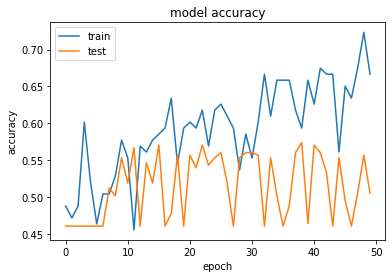

In [80]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Model 2
Activation = relu  
No Dropout

In [92]:
model = K.models.Sequential()
model.add(K.layers.Conv2D(93, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.Conv2D(50, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
# model.add(K.layers.MaxPooling2D((2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(32, activation= 'relu'))
model.add(K.layers.Dropout(0.15))
model.add(K.layers.Dense(2,activation='relu'))

In [82]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 1, 93)          77934     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 50)          4700      
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 32)                1632      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 66        
Total params: 84,332
Trainable params: 84,332
Non-trainable params: 0
_________________________________________________

In [93]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0003, decay=1e-2)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h2 = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
31/31 [==============================] - 1s 20ms/step - loss: nan - accuracy: 0.5041 - val_loss: nan - val_accuracy: 0.4708
Epoch 2/50
31/31 [==============================] - 0s 15ms/step - loss: nan - accuracy: 0.5691 - val_loss: nan - val_accuracy: 0.4742
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.4878 - val_loss: nan - val_accuracy: 0.4742
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.5447 - val_loss: nan - val_accuracy: 0.4639
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.5122 - val_loss: nan - val_accuracy: 0.4639
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.4390 - val_loss: nan - val_accuracy: 0.4605
Epoch 7/50
31/31 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.5447 - val_loss: nan - val_accuracy: 0.4639
Epoch 8/50
31/31 [==============================] - 0s 9ms

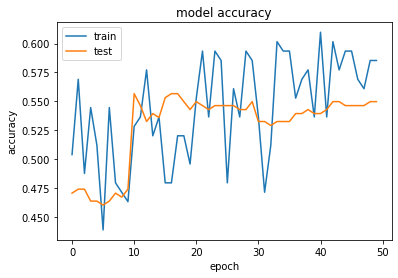

In [94]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()